In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Load Dataset
gpt_evaluations = pd.read_csv('./dataset_final.csv')
gpt_evaluations_sampled = (
    gpt_evaluations.groupby('model_name', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 1200), random_state=42))
    .reset_index(drop=True)
)

/tmp/ipykernel_797373/2618969047.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 1200), random_state=42))


In [45]:
# Print the number of samples for each model_name
print(gpt_evaluations_sampled['model_name'].value_counts())

model_name
out-full-wfull-54M-r5    1200
out-local-w128-54M-r8    1200
out-local-w16-54M-r11    1200
out-local-w2-54M-r15     1200
out-local-w32-54M-r10    1200
out-local-w64-54M-r9     1200
out-slide-w128-54M-r9    1200
out-slide-w16-54M-r5     1200
out-slide-w2-54M-r10     1200
out-slide-w32-54M-r6     1200
out-slide-w64-54M-r7     1200
Name: count, dtype: int64


In [29]:
# Show sample dataset
gpt_evaluations_sampled.head()

,id,model_name,sentence,grammatical_correctness,readability,descriptiveness,coherence,conciseness,explanation,seed
0,14692,out-full-wfull-54M-r5,I enjoy watching soccer. How about you? What s...,9,9,8,8,9,"The conversation is mostly fluid, but the pres...",58879
1,10915,out-full-wfull-54M-r5,That sounds like the perfect way to end the da...,9,8,9,9,8,"Overall, the message is understood well, but t...",204334
2,11738,out-full-wfull-54M-r5,"The piano is such a versatile instrument, I ca...",9,9,9,9,9,The sentence is well-structured and easy to un...,752993
3,5006,out-full-wfull-54M-r5,A forest like that must feel like a whole expe...,9,8,8,8,9,"The sentence is clear, but may lack a bit of p...",175940
4,10233,out-full-wfull-54M-r5,"Absolutely, exploring different narrative styl...",9,9,9,9,9,The flow and structure of the sentences are st...,879811


In [30]:
# Store result gruoped in a dictionary
models_dict = {name: group for name, group in gpt_evaluations_sampled.groupby('model_name')}
full_attention_model = models_dict['out-full-wfull-54M-r5']

fixed_attention_models = {k: v for k, v in models_dict.items() if 'local' in k}
sliding_attention_models = {k: v for k, v in models_dict.items() if 'slide' in k}
model_names = models_dict.keys()
# model_names



In [31]:
fixed_attention_models.keys()
len(fixed_attention_models.keys())

5

In [32]:
sliding_attention_models.keys()
len(fixed_attention_models.keys())

5

In [33]:
num_models = len(model_names) # There are 11 Models
num_models

11

In [34]:
metrics = ['grammatical_correctness', 'readability', 'descriptiveness', 'coherence', 'conciseness']
summary_table = gpt_evaluations_sampled.groupby('model_name')[metrics].mean().reset_index()
display(summary_table.style.hide(axis="index"))

model_name,grammatical_correctness,readability,descriptiveness,coherence,conciseness
out-full-wfull-54M-r5,8.807500,8.650833,8.502500,8.686667,8.149167
out-local-w128-54M-r8,8.749167,8.488333,8.465000,8.559167,8.056667
out-local-w16-54M-r11,7.575000,7.469167,7.545000,7.300833,6.981667
out-local-w2-54M-r15,5.897500,5.820000,6.284167,5.301667,5.460833
out-local-w32-54M-r10,8.298333,8.103333,8.108333,7.901667,7.659167
out-local-w64-54M-r9,8.580833,8.395000,8.363333,8.374167,7.914167
out-slide-w128-54M-r9,5.861667,5.763333,6.285000,5.404167,5.455000
out-slide-w16-54M-r5,5.642500,5.559167,6.093333,5.092500,5.160833
out-slide-w2-54M-r10,5.523333,5.442500,5.955000,5.058333,5.085000
out-slide-w32-54M-r6,5.835000,5.690000,6.264167,5.260000,5.268333


In [35]:
metrics = ['grammatical_correctness', 'readability', 'descriptiveness', 'coherence', 'conciseness']
summary_table = gpt_evaluations_sampled.groupby('model_name')[metrics].mean().reset_index()

# Add average score column
summary_table['average_score'] = summary_table[metrics].mean(axis=1)

# Sort by average score (descending) and add rank
summary_table = summary_table.sort_values(by='average_score', ascending=False).reset_index(drop=True)
summary_table['rank'] = summary_table.index + 1

summary_table

,model_name,grammatical_correctness,readability,descriptiveness,coherence,conciseness,average_score,rank
0,out-full-wfull-54M-r5,8.807500,8.650833,8.502500,8.686667,8.149167,8.559333,1
1,out-local-w128-54M-r8,8.749167,8.488333,8.465000,8.559167,8.056667,8.463667,2
2,out-local-w64-54M-r9,8.580833,8.395000,8.363333,8.374167,7.914167,8.325500,3
3,out-local-w32-54M-r10,8.298333,8.103333,8.108333,7.901667,7.659167,8.014167,4
4,out-local-w16-54M-r11,7.575000,7.469167,7.545000,7.300833,6.981667,7.374333,5
5,out-slide-w128-54M-r9,5.861667,5.763333,6.285000,5.404167,5.455000,5.753833,6
6,out-local-w2-54M-r15,5.897500,5.820000,6.284167,5.301667,5.460833,5.752833,7
7,out-slide-w64-54M-r7,5.770833,5.766667,6.251667,5.364167,5.374167,5.705500,8
8,out-slide-w32-54M-r6,5.835000,5.690000,6.264167,5.260000,5.268333,5.663500,9
9,out-slide-w16-54M-r5,5.642500,5.559167,6.093333,5.092500,5.160833,5.509667,10


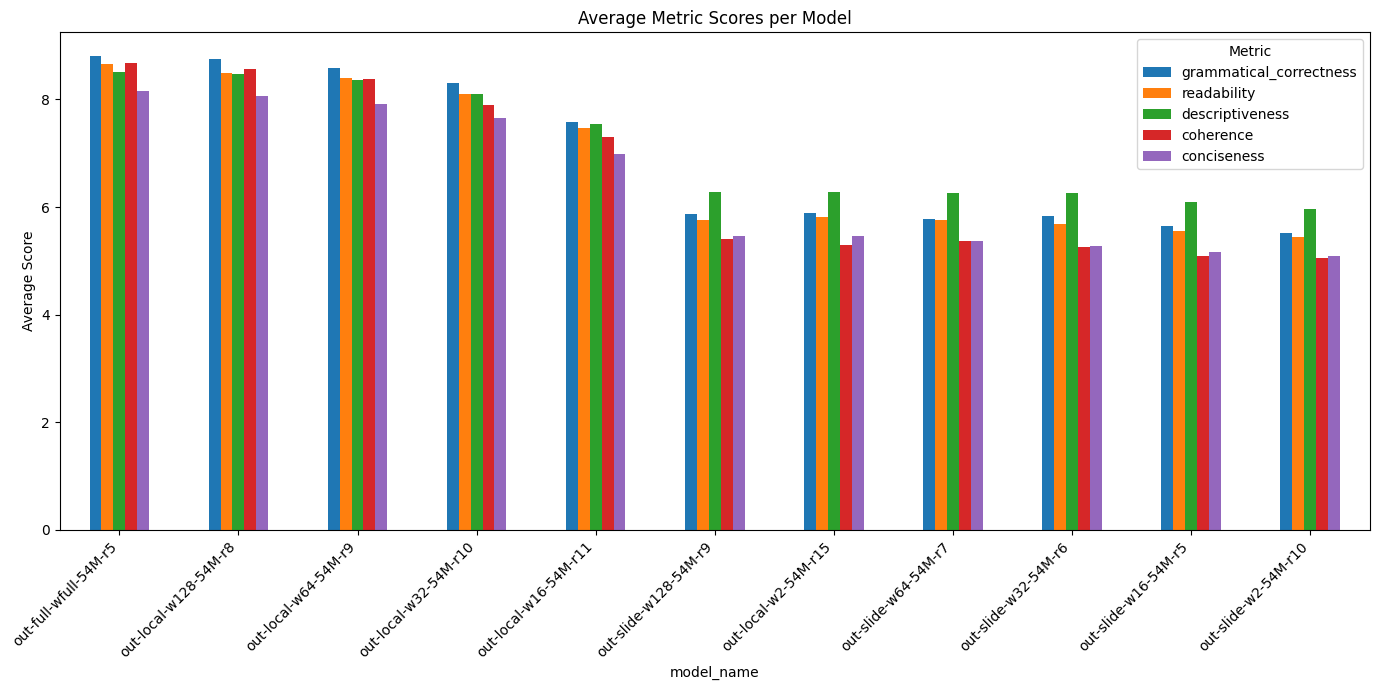

In [36]:
summary_table.set_index('model_name')[metrics].plot(kind='bar', figsize=(14, 7))
plt.ylabel('Average Score')
plt.title('Average Metric Scores per Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

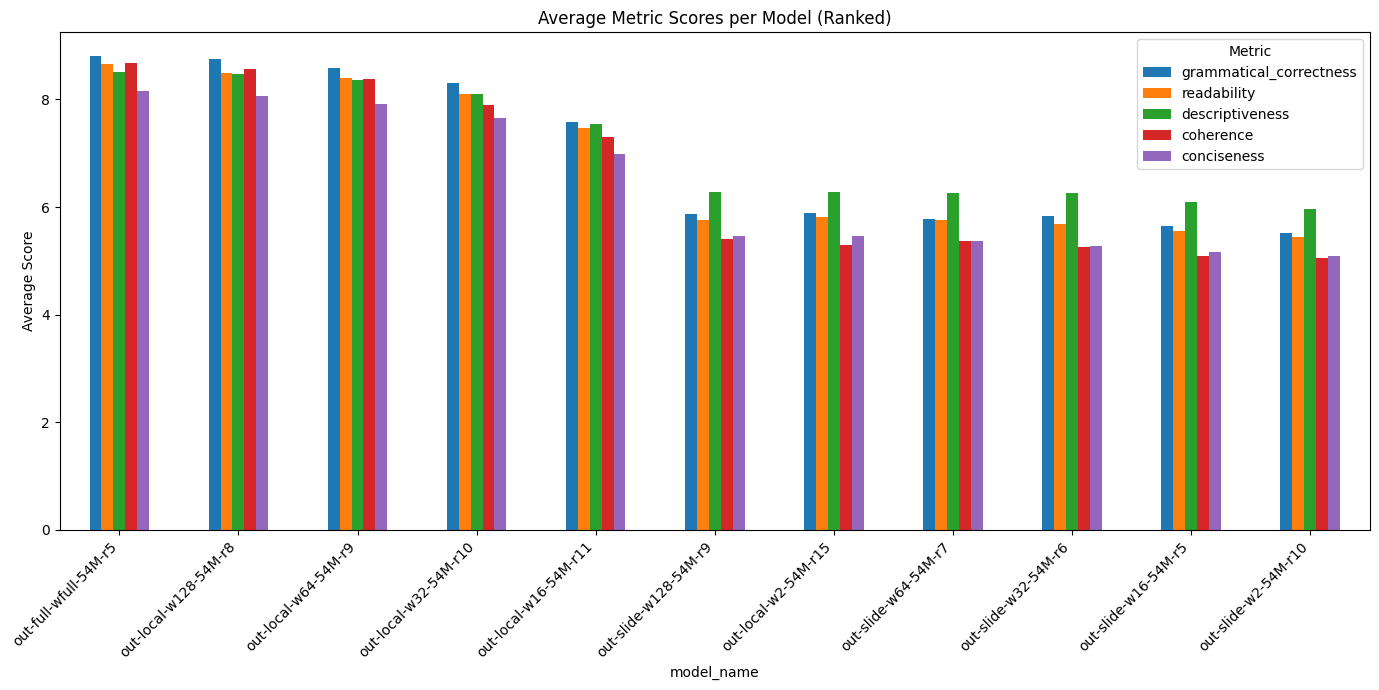

In [37]:
# Add average score column
summary_table['average_score'] = summary_table[metrics].mean(axis=1)

# Sort by average score (descending)
summary_table_ranked = summary_table.sort_values(by='average_score', ascending=False)

# Plot using the ranked table
summary_table_ranked.set_index('model_name')[metrics].plot(kind='bar', figsize=(14, 7))
plt.ylabel('Average Score')
plt.title('Average Metric Scores per Model (Ranked)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [38]:
def plot_radar(model_row, metrics):
    values = model_row[metrics].values.flatten().tolist()
    values += values[:1]  # repeat first value to close the circle
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(f"Radar Plot for {model_row['model_name']}")
    plt.show()

# for idx, row in summary_table.iterrows():
#     plot_radar(row, metrics)

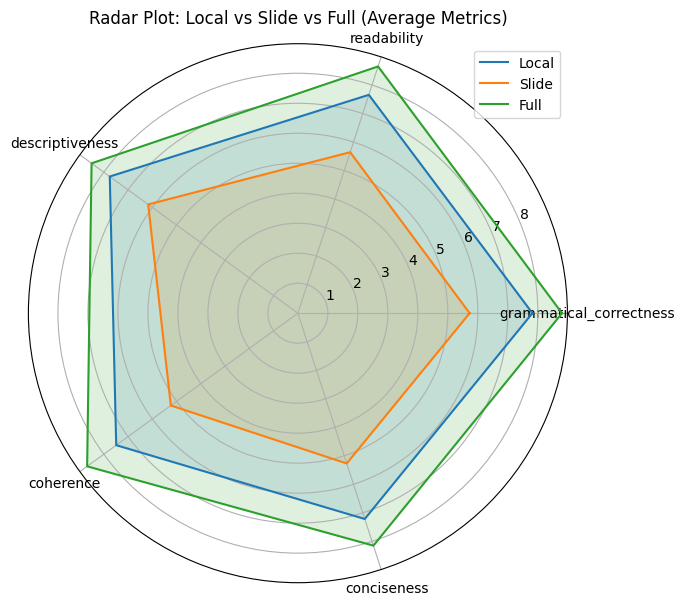

In [39]:
# Group model types
groups = {
    'local': summary_table[summary_table['model_name'].str.contains('local')],
    'slide': summary_table[summary_table['model_name'].str.contains('slide')],
    'full': summary_table[summary_table['model_name'].str.contains('full')],
}

# Calculate average metrics for each group
group_averages = {k: v[metrics].mean().tolist() for k, v in groups.items()}

# Radar plot setup
labels = metrics
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for group, values in group_averages.items():
    stats = values + values[:1]  # close the circle
    ax.plot(angles, stats, label=group.capitalize())
    ax.fill(angles, stats, alpha=0.15)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Plot: Local vs Slide vs Full (Average Metrics)")
plt.legend(loc='upper right')
plt.show()

In [40]:
# Calculate the average score across all metrics for each model
summary_table['average_score'] = summary_table[metrics].mean(axis=1)

# Sort models by average_score in descending order (best model first)
ranked_table = summary_table.sort_values(by='average_score', ascending=False).reset_index(drop=True)

# Add a rank column
ranked_table['rank'] = ranked_table.index + 1

# Display the ranked table
ranked_table[['rank', 'model_name', 'average_score']]
display(ranked_table[['rank', 'model_name', 'average_score']].style.hide(axis="index"))

rank,model_name,average_score
1,out-full-wfull-54M-r5,8.559333
2,out-local-w128-54M-r8,8.463667
3,out-local-w64-54M-r9,8.325500
4,out-local-w32-54M-r10,8.014167
5,out-local-w16-54M-r11,7.374333
6,out-slide-w128-54M-r9,5.753833
7,out-local-w2-54M-r15,5.752833
8,out-slide-w64-54M-r7,5.705500
9,out-slide-w32-54M-r6,5.663500
10,out-slide-w16-54M-r5,5.509667


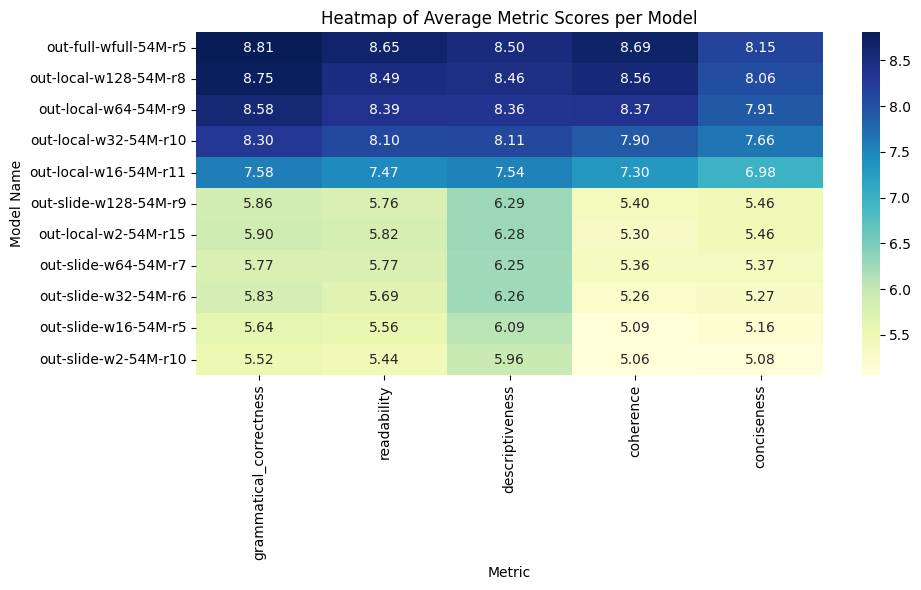

In [41]:
# Set model_name as index for the heatmap
heatmap_data = summary_table.set_index('model_name')[metrics]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Heatmap of Average Metric Scores per Model')
plt.ylabel('Model Name')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

In [42]:
# Get the benchmark score
benchmark_score = ranked_table.loc[ranked_table['model_name'] == 'out-full-wfull-54M-r5', 'average_score'].values[0]

# Calculate percentage of benchmark for each model
ranked_table['percent_of_benchmark'] = (ranked_table['average_score'] / benchmark_score) * 100

# Display the updated table
ranked_table[['rank', 'model_name', 'average_score', 'percent_of_benchmark']]# Display the updated table without the index
display(ranked_table[['rank', 'model_name', 'average_score', 'percent_of_benchmark']].style.hide(axis="index"))

rank,model_name,average_score,percent_of_benchmark
1,out-full-wfull-54M-r5,8.559333,100.000000
2,out-local-w128-54M-r8,8.463667,98.882312
3,out-local-w64-54M-r9,8.325500,97.268089
4,out-local-w32-54M-r10,8.014167,93.630734
5,out-local-w16-54M-r11,7.374333,86.155464
6,out-slide-w128-54M-r9,5.753833,67.222915
7,out-local-w2-54M-r15,5.752833,67.211231
8,out-slide-w64-54M-r7,5.705500,66.658229
9,out-slide-w32-54M-r6,5.663500,66.167536
10,out-slide-w16-54M-r5,5.509667,64.370278


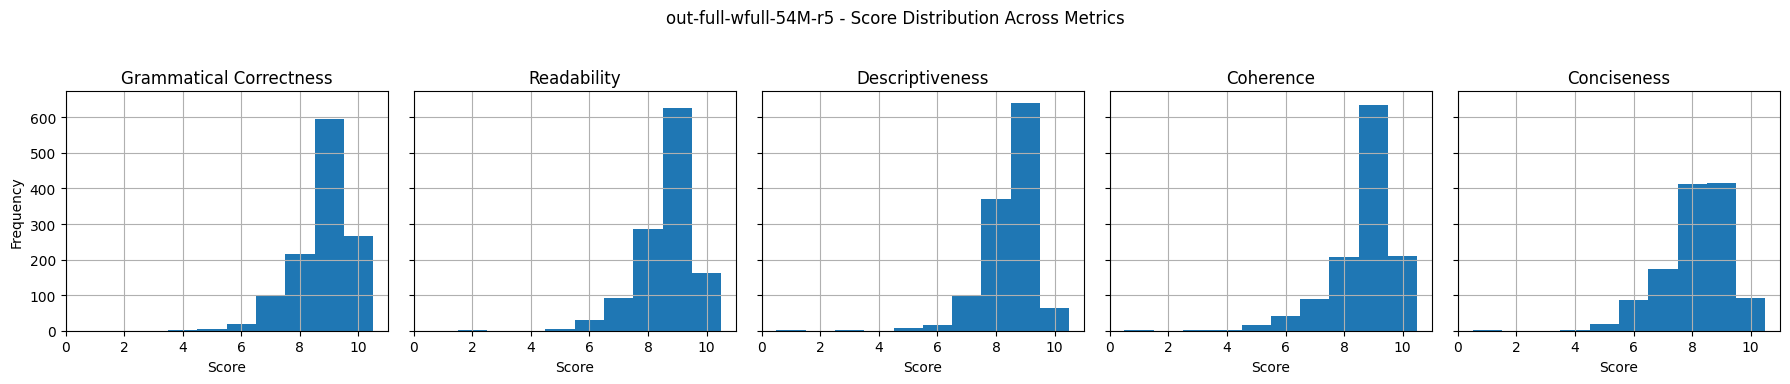

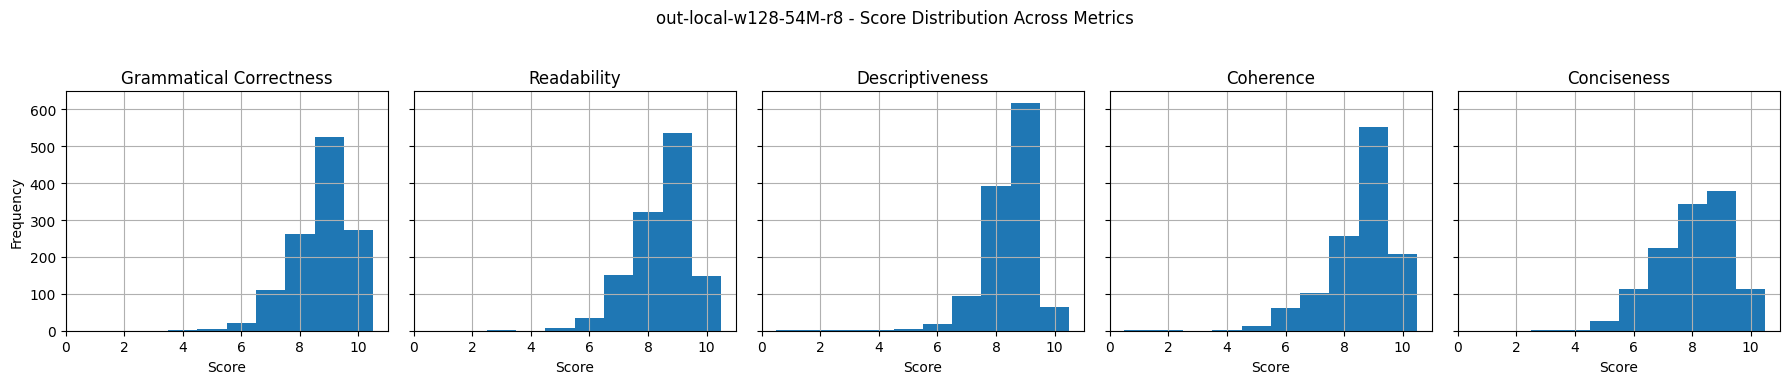

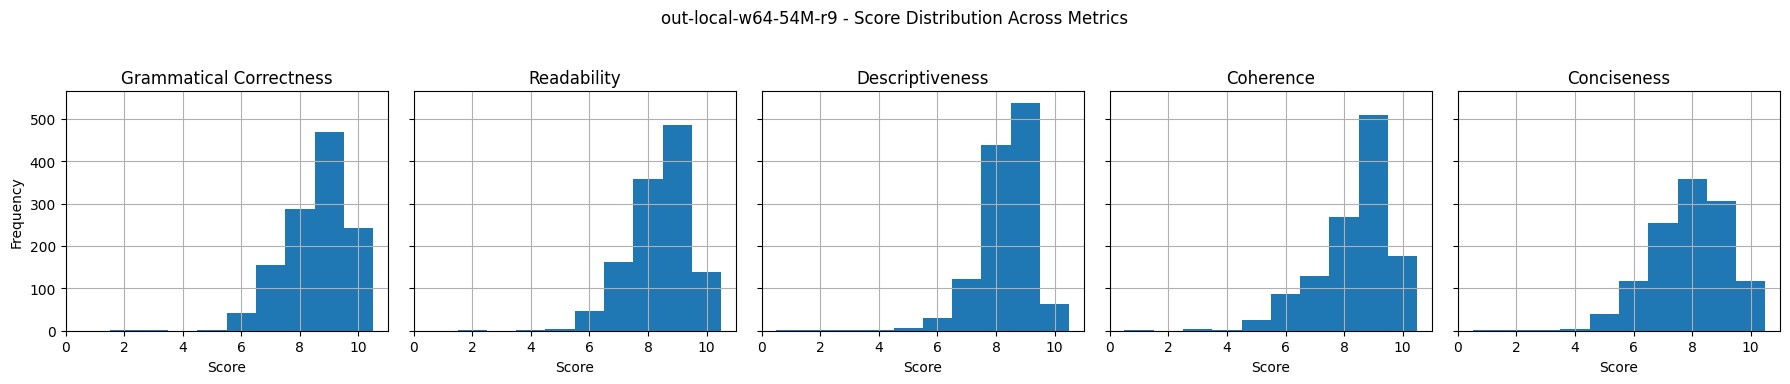

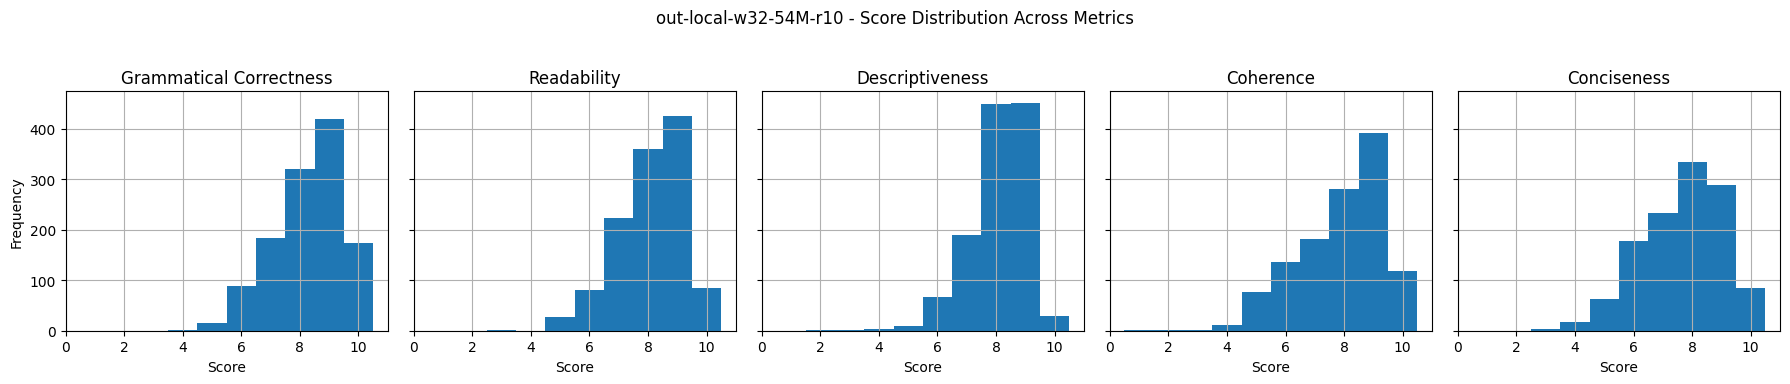

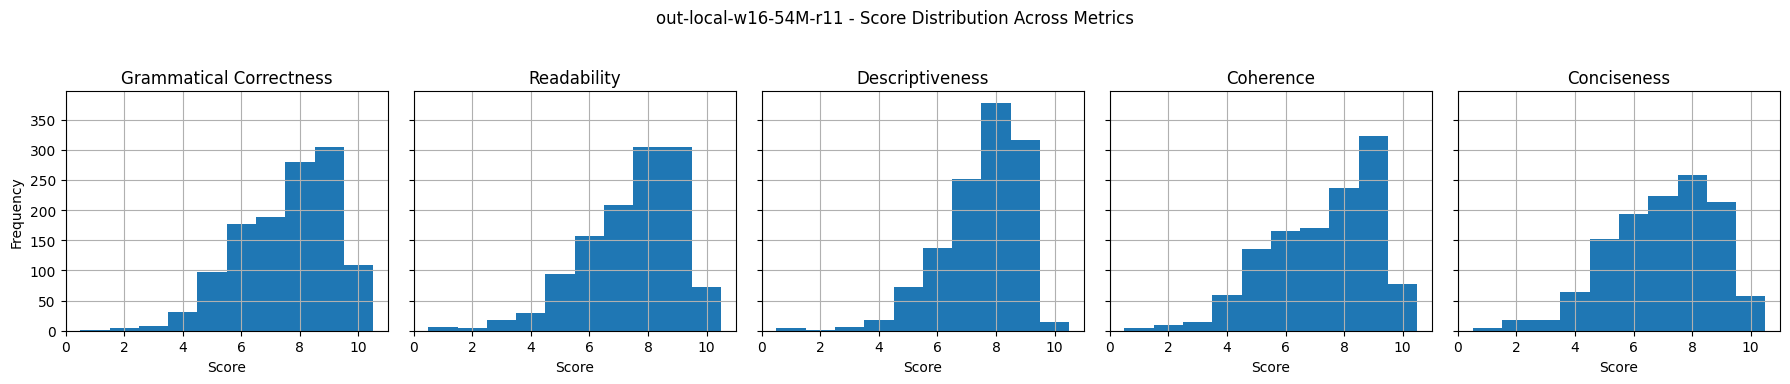

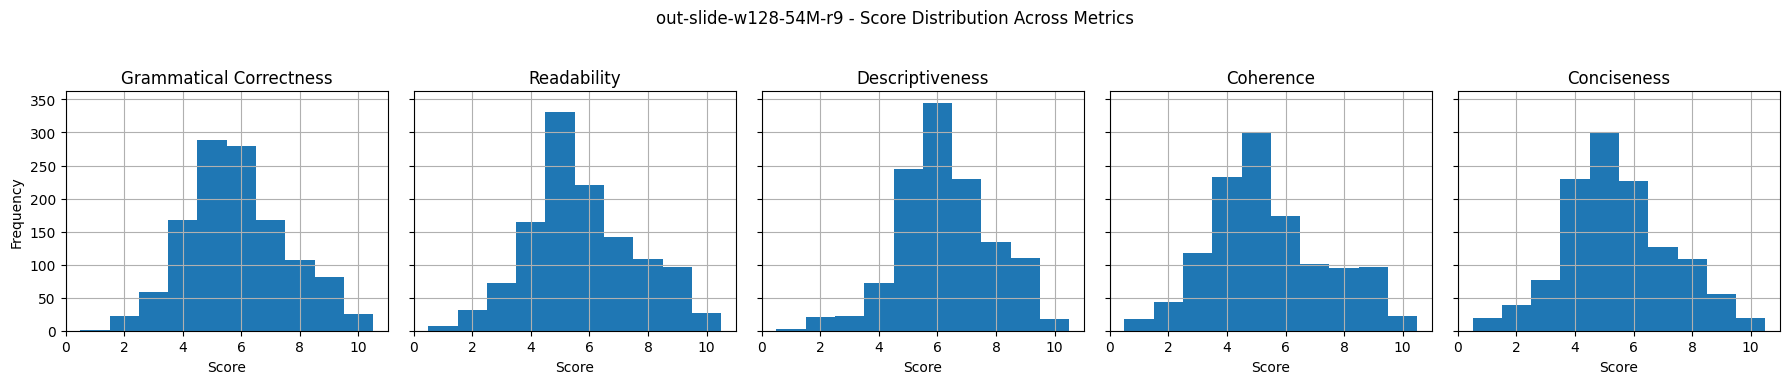

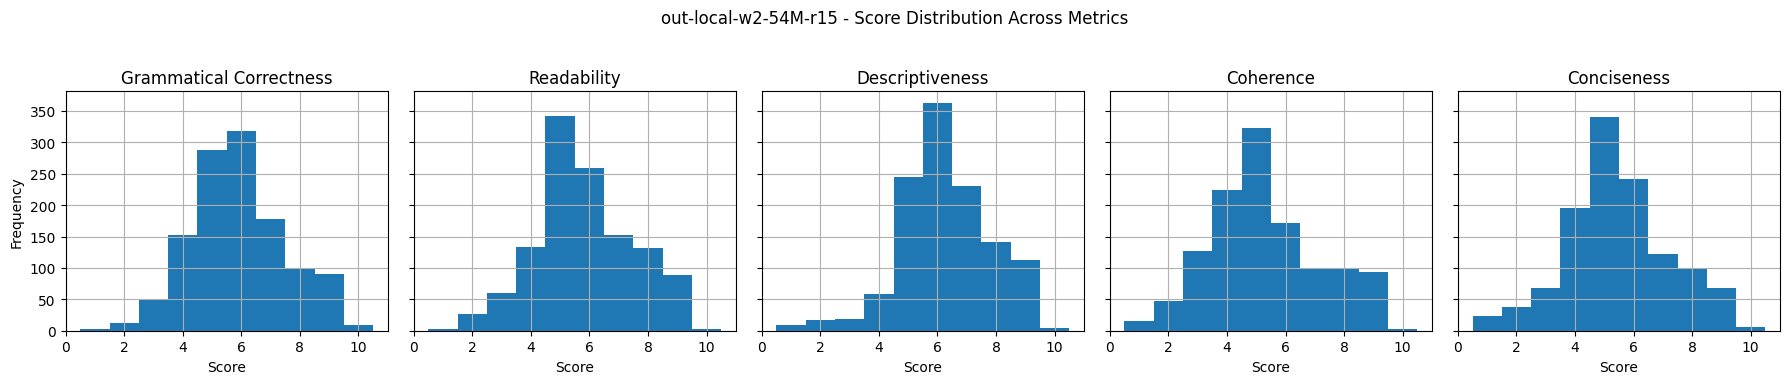

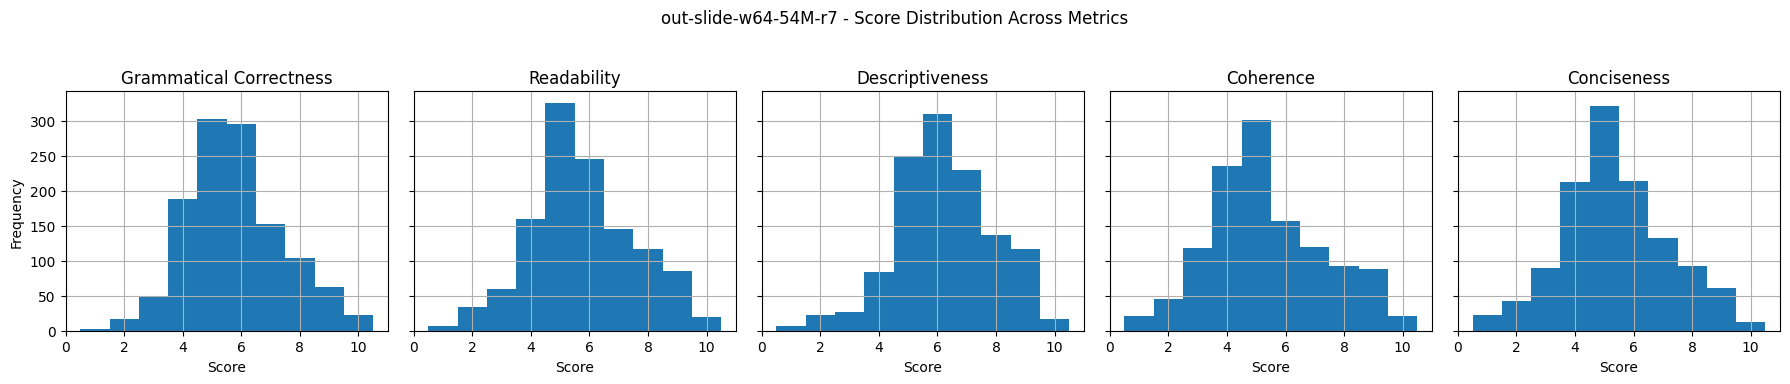

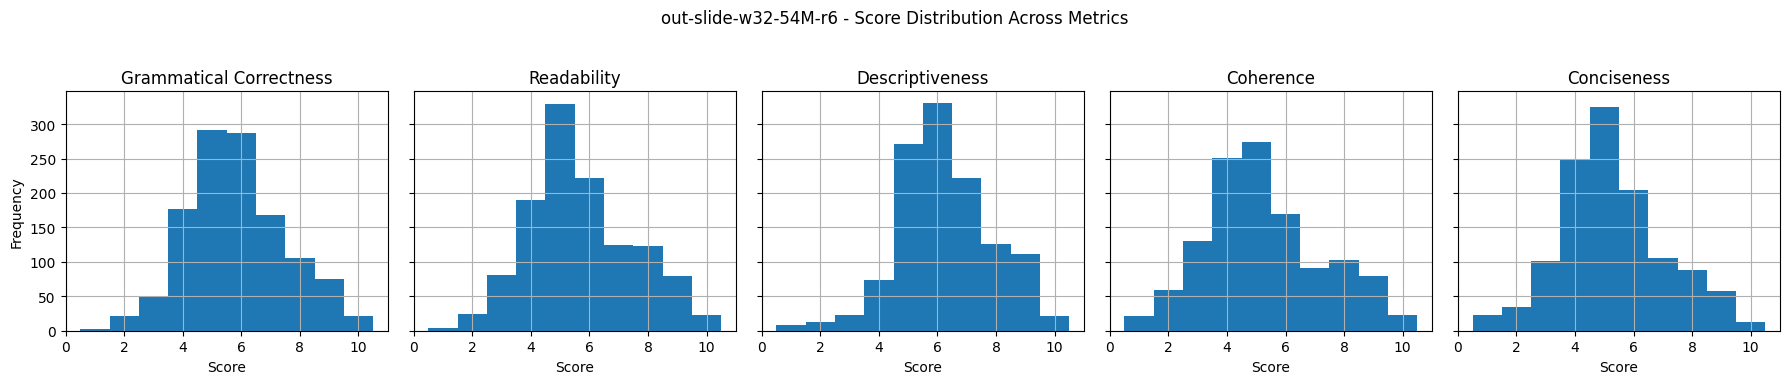

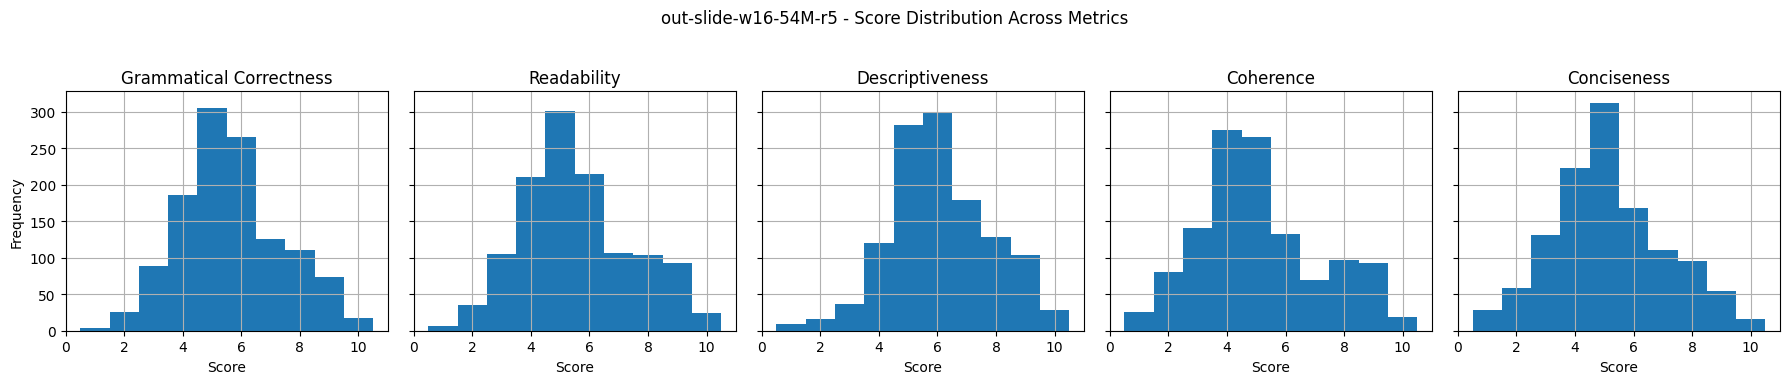

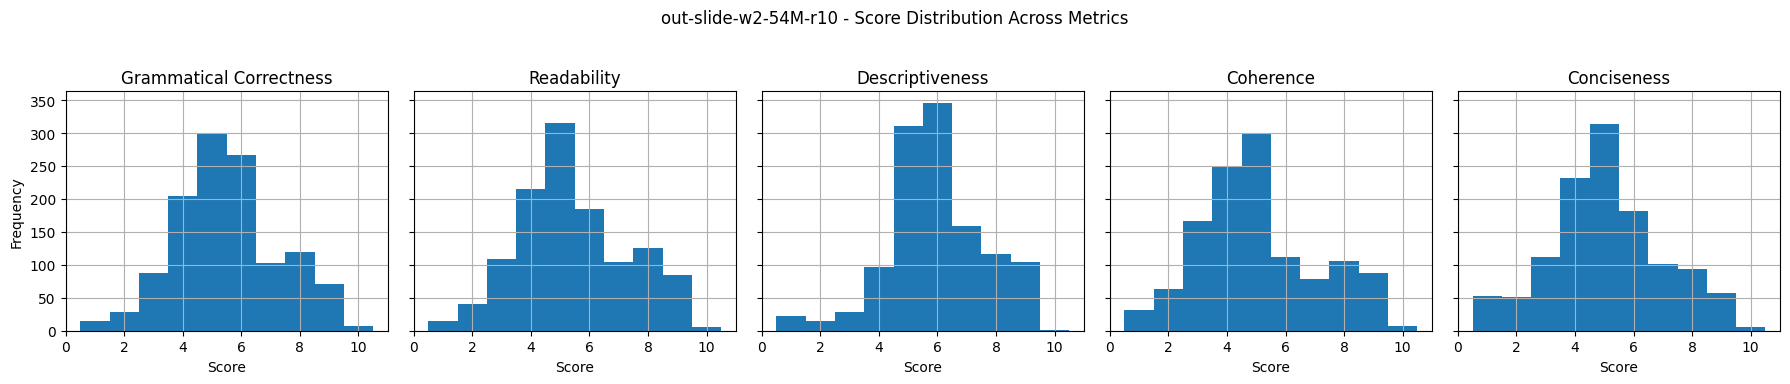

In [43]:
# Get sorted model names by average_score (descending)
sorted_models = ranked_table.sort_values(by='average_score', ascending=False)['model_name']

for model in sorted_models:
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 4), sharey=True)
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        gpt_evaluations_sampled[gpt_evaluations_sampled['model_name'] == model][metric].hist(
            bins=range(1, 12), align='left', ax=ax
        )
        ax.set_title(metric.replace('_', ' ').title())
        ax.set_xlabel('Score')
        if idx == 0:
            ax.set_ylabel('Frequency')
    plt.suptitle(f'{model} - Score Distribution Across Metrics')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()